In [1]:
import pandas as pd
import numpy as np
import time_series_module as tsm
import time_series_cross_valid as tscv
import time_series_versioning as tsver
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
from importlib import reload

In [2]:
df = pd.read_csv('train.csv')
df['date_time'] = pd.to_datetime(df['date_time'])
date_time_features_names = tsm.get_date_time_features(df, 'date_time', True, True, True, True, True)
date_time_features = df[date_time_features_names].copy()
date_time_column = df['date_time'].copy()
df.drop(columns = date_time_features_names + ['date_time'], inplace = True)

In [3]:
targets = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']

In [4]:
f_dict = {}
df = tsm.feature_extractor(features_dict = f_dict, data_frame = df, inplace = True, STL = [date_time_column, targets, True, False, 'additive'])
#df = tsm.feature_extractor(features_dict = f_dict, data_frame = df, inplace = True, lagged = [list(df.columns), 24, False])

In [5]:
df.dropna(inplace = True)
date_time_features = date_time_features.loc[list(df.index),:]
date_time_column = date_time_column[df.index]
df.index, date_time_column.index, date_time_features.index = [list(range(len(df)))]*3

In [6]:
def get_feature_list(data):
    return [f for f in list(df.columns) if f not in targets and f != 'date_time']

In [7]:
features = get_feature_list(df)

data_versions = tsver.DataVersions()
data_versions.push(tsver.nested_data(df, features, targets, targets, [date_time_column, date_time_features]), 
                   key = 'original_data')
data_versions.save_with_pickle('original_data')

In [8]:
rcParams['figure.figsize'] = 20, 8

In [9]:
def mape(y, y_hat):
    return 100*np.abs(y - y_hat) / y

In [10]:
features

['deg_C',
 'relative_humidity',
 'absolute_humidity',
 'sensor_1',
 'sensor_2',
 'sensor_3',
 'sensor_4',
 'sensor_5',
 'trend_target_carbon_monoxide',
 'seasonal_target_carbon_monoxide',
 'resid_target_carbon_monoxide',
 'trend_target_benzene',
 'seasonal_target_benzene',
 'resid_target_benzene',
 'trend_target_nitrogen_oxides',
 'seasonal_target_nitrogen_oxides',
 'resid_target_nitrogen_oxides']

### Ridge regression

In [11]:
from sklearn.linear_model import Ridge

In [12]:
class RidgeModel:
    def __init__(self, ridge):
        self.ridge = ridge
    def fit(self, X,Y):
        fitted_model = self.ridge.fit(X, Y)
        self.importances = fitted_model.coef_
        return fitted_model
    def predict(self, X):
        return self.ridge.predict(X)

In [13]:
ridge_horizons = 12
ridge_model = RidgeModel(Ridge(alpha = .001, normalize = True))
ridge_CrossValid_params = {'train_size' : 2000, 'test_size' : 1, 'min_period' : 0, 'step' : 500}
ridge_ForecastModel_params = {'features' : features, 'date_time' : date_time_features,
                              'prior_lag' : 24, 'post_lag' : 0, 'new_index' : True}

In [18]:
ridge_quality = tscv.run_cv(data = df, targets = targets, horizons = ridge_horizons, CrossValid_params = ridge_CrossValid_params, 
            ForecastModel_params = ridge_ForecastModel_params, model = ridge_model, metrics = mape)

/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_' + c + '_' + str(l)] = lagged(data, c, l)
/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_' + c + '_' + str(l)] = lagged(data, c, l)
/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented fra

/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_' + c + '_' + str(l)] = lagged(data, c, l)
/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_' + c + '_' + str(l)] = lagged(data, c, l)
/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented fra

target_carbon_monoxide


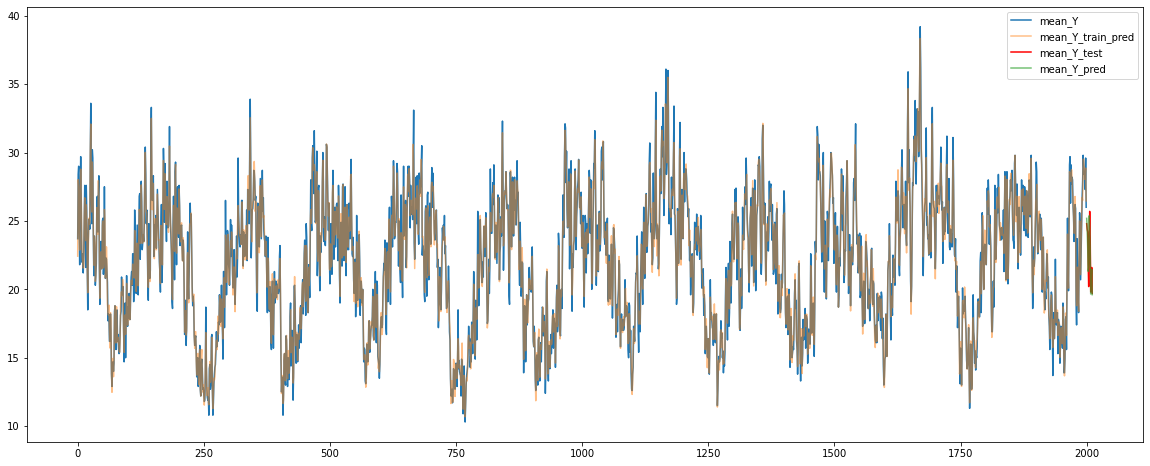

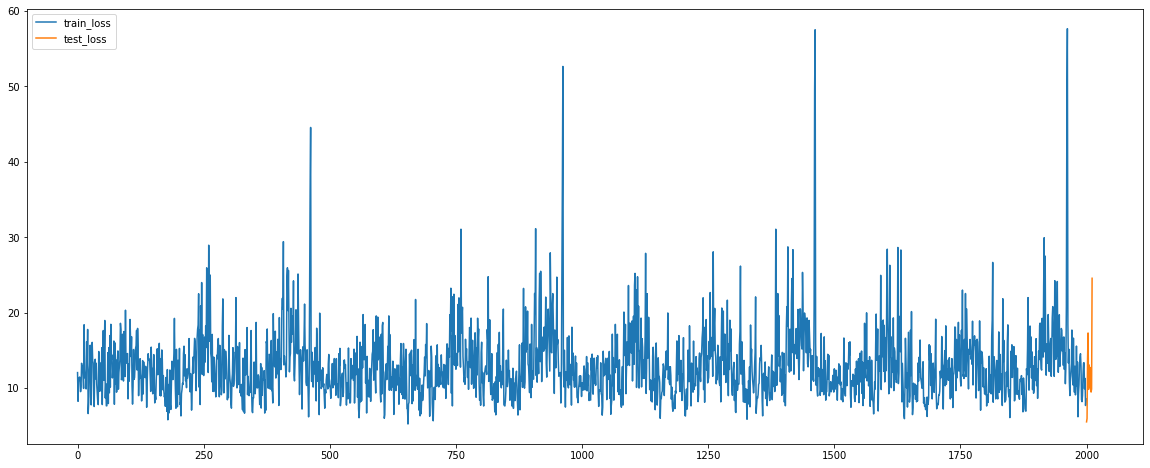

target_benzene


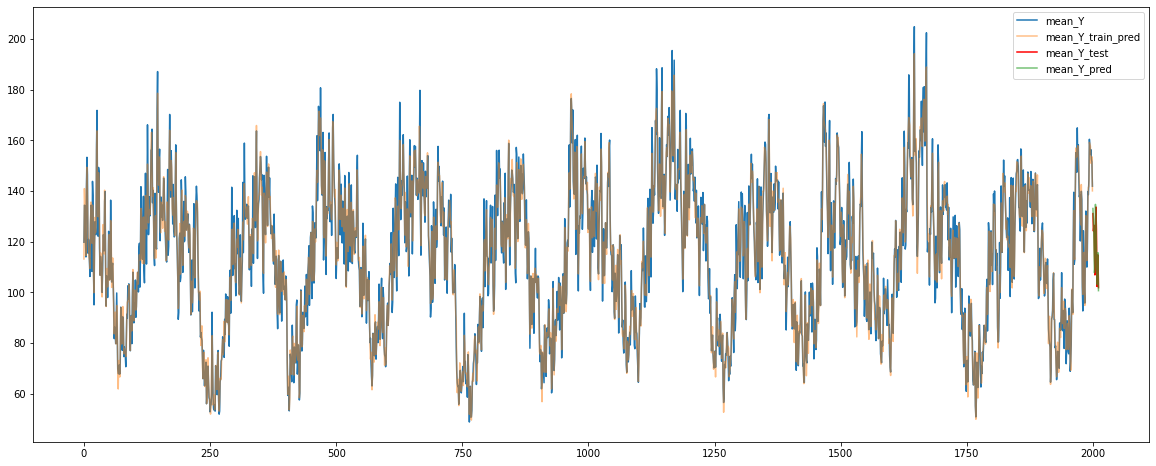

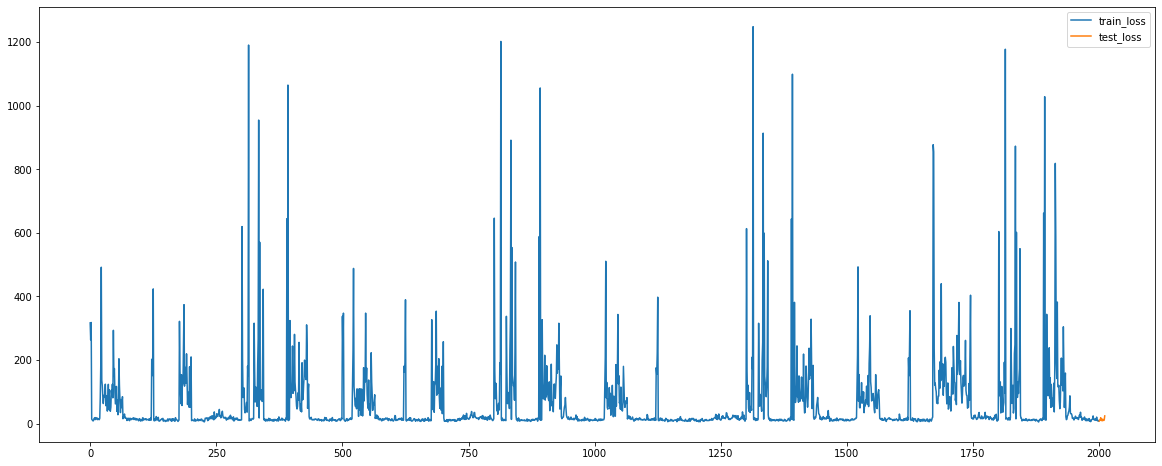

target_nitrogen_oxides


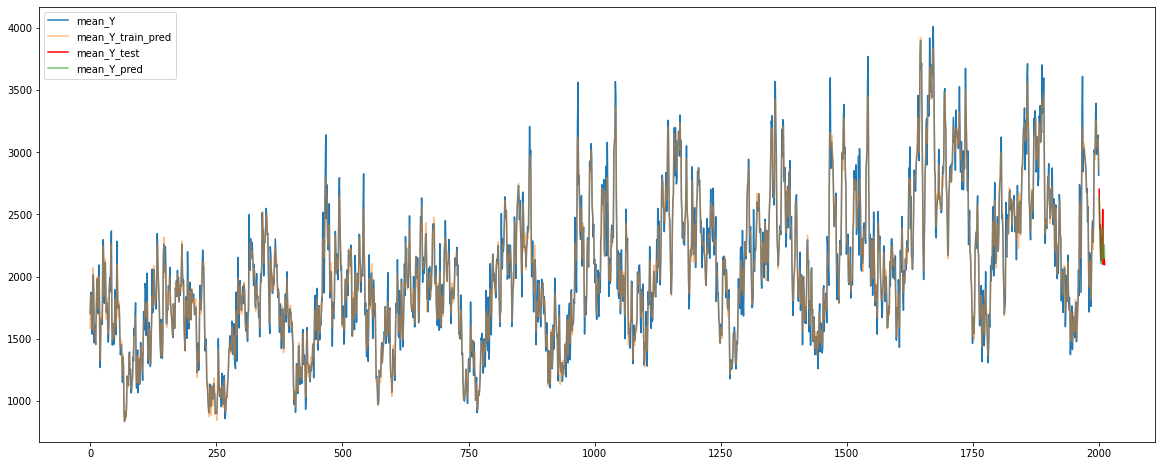

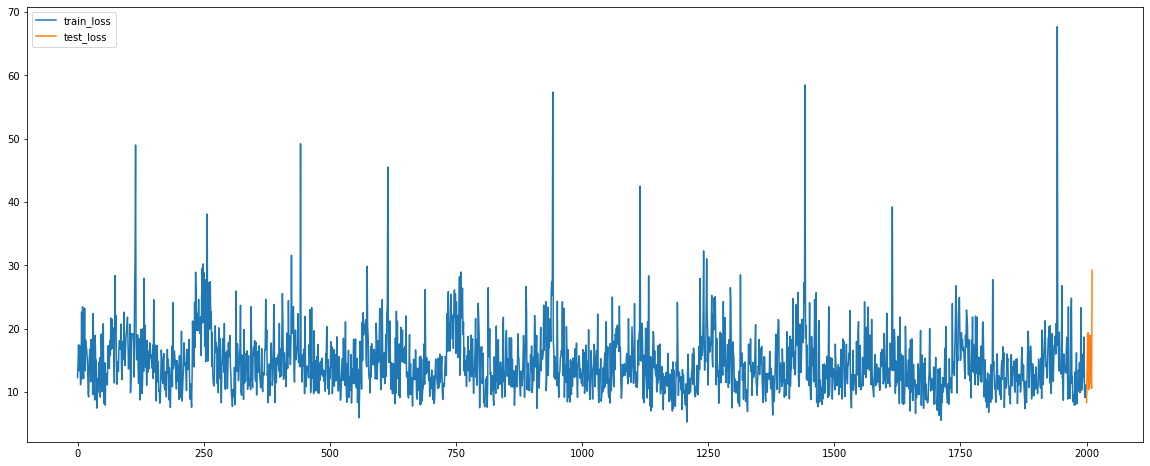

In [19]:
tscv.plot_cv_results(quality = ridge_quality, horizons = ridge_horizons, plot_loss = True)

In [39]:
reload(tscv)

<module 'time_series_cross_valid' from '/home/alexey/notebooks/EPAM/practice_1/time_series_cross_valid.py'>

In [71]:
ridge_importances_dict = tscv.get_importances(ridge_quality, ridge_horizons)
ridge_imp_features_0 = list(ridge_importances_dict['target_carbon_monoxide'][0][(ridge_importances_dict['target_carbon_monoxide'][0] >= .2) | (ridge_importances_dict['target_carbon_monoxide'][0] <= -0.2)].index)
ridge_imp_features_1 = list(ridge_importances_dict['target_benzene'][0][(ridge_importances_dict['target_benzene'][0] >= 1) | (ridge_importances_dict['target_benzene'][0] <= -1)].index)
ridge_imp_features_2 = list(ridge_importances_dict['target_nitrogen_oxides'][0][(ridge_importances_dict['target_nitrogen_oxides'][0] >= 1) | (ridge_importances_dict['target_nitrogen_oxides'][0] <= -1)].index)

In [72]:
ridge_imp_features_0

['lag_trend_target_carbon_monoxide_1',
 'lag_trend_target_carbon_monoxide_2',
 'lag_trend_target_carbon_monoxide_3',
 'lag_trend_target_carbon_monoxide_4',
 'lag_trend_target_carbon_monoxide_5',
 'lag_trend_target_carbon_monoxide_10',
 'lag_trend_target_carbon_monoxide_11',
 'lag_trend_target_carbon_monoxide_12',
 'lag_trend_target_carbon_monoxide_13',
 'lag_trend_target_carbon_monoxide_14',
 'lag_trend_target_carbon_monoxide_15',
 'lag_trend_target_carbon_monoxide_16',
 'lag_trend_target_carbon_monoxide_17',
 'lag_trend_target_carbon_monoxide_18',
 'lag_trend_target_carbon_monoxide_19',
 'lag_trend_target_carbon_monoxide_20',
 'lag_trend_target_carbon_monoxide_21',
 'lag_trend_target_carbon_monoxide_22',
 'lag_seasonal_target_carbon_monoxide_11',
 'lag_seasonal_target_carbon_monoxide_12',
 'lag_resid_target_carbon_monoxide_1',
 'lag_resid_target_carbon_monoxide_2',
 'lag_resid_target_carbon_monoxide_3',
 'lag_resid_target_carbon_monoxide_4',
 'lag_resid_target_carbon_monoxide_5',
 'la

### Decision Tree

In [73]:
from sklearn.tree import DecisionTreeRegressor

In [84]:
class DTRegModel:
    def __init__(self, model):
        self.model = model
    def fit(self, X, Y):
        fitted_model = self.model.fit(X, Y)
        self.importances = fitted_model.feature_importances_
        return fitted_model
    def predict(self, X):
        return self.model.predict(X)
    

In [86]:
dtreg_model = DTRegModel(DecisionTreeRegressor(max_depth = 5))
dtreg_horizons = 12
dtreg_CrossValid_params = {'train_size' : 2000, 'test_size' : 1, 'min_period' : 0, 'step' : 500}
dtreg_ForecastModel_params = {'features' : features, 'date_time' : date_time_features,
                              'prior_lag' : 24, 'post_lag' : 0, 'new_index' : True}

In [88]:
dtreg_quality = tscv.run_cv(data = df, targets = targets, horizons = dtreg_horizons, CrossValid_params = dtreg_CrossValid_params, 
            ForecastModel_params = dtreg_ForecastModel_params, model = dtreg_model, metrics = mape)

/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_' + c + '_' + str(l)] = lagged(data, c, l)
/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_' + c + '_' + str(l)] = lagged(data, c, l)
/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented fra

/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_' + c + '_' + str(l)] = lagged(data, c, l)
/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_' + c + '_' + str(l)] = lagged(data, c, l)
/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented fra

target_carbon_monoxide


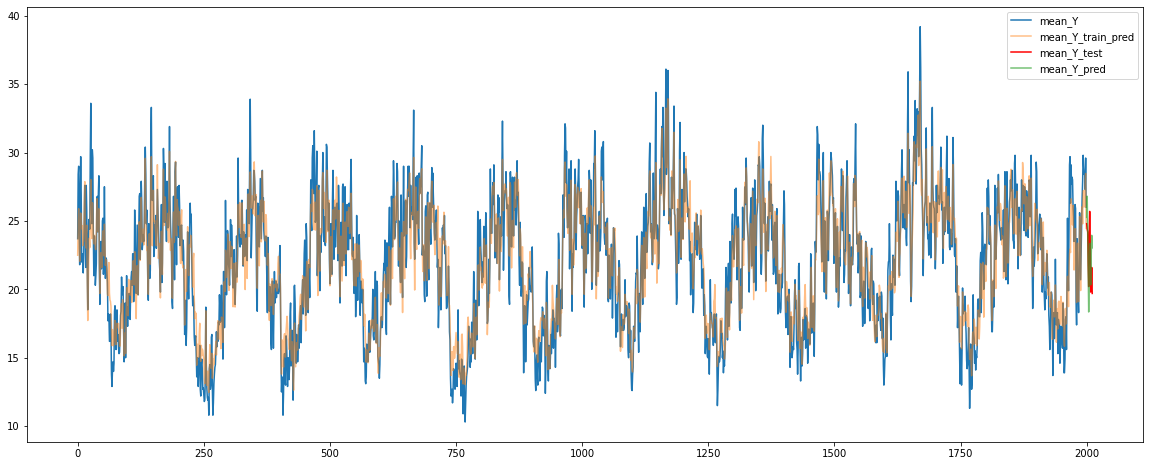

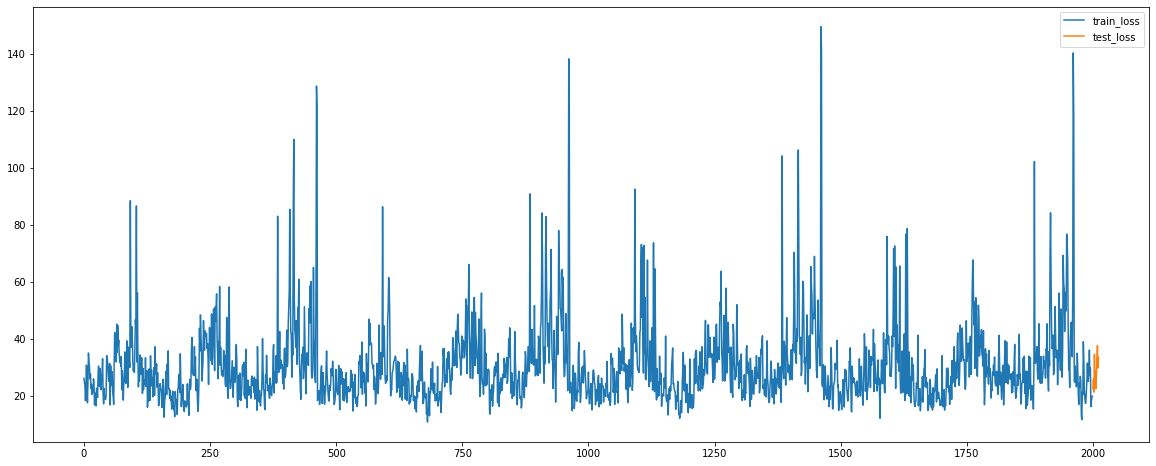

target_benzene


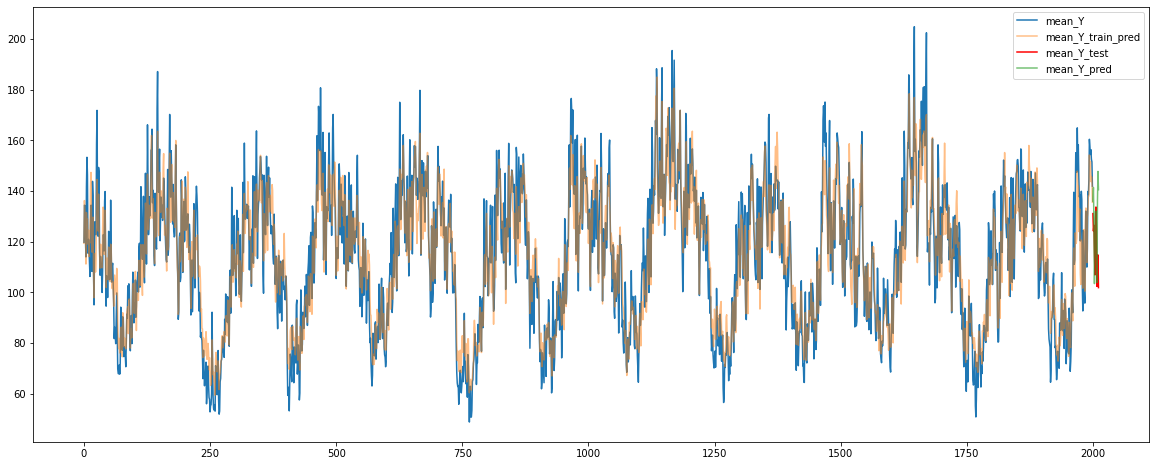

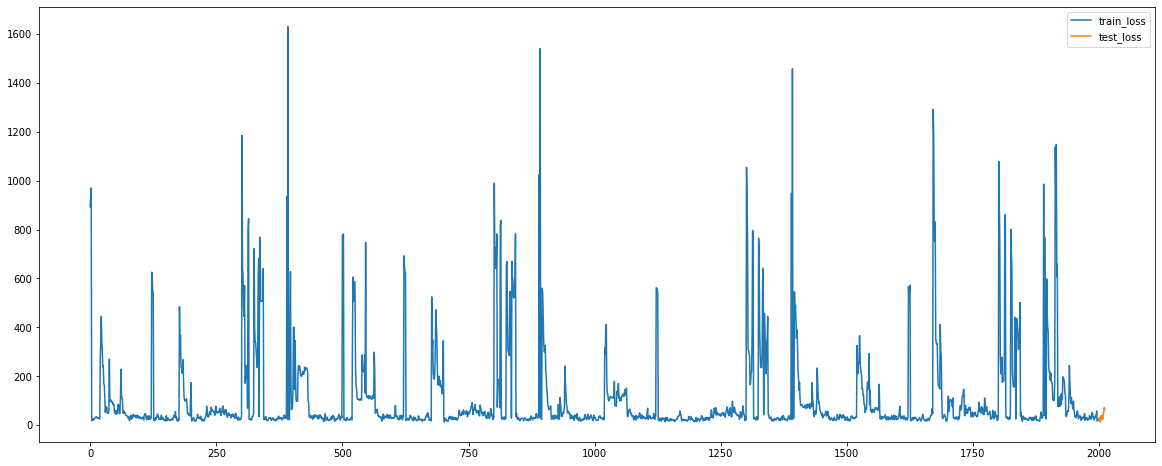

target_nitrogen_oxides


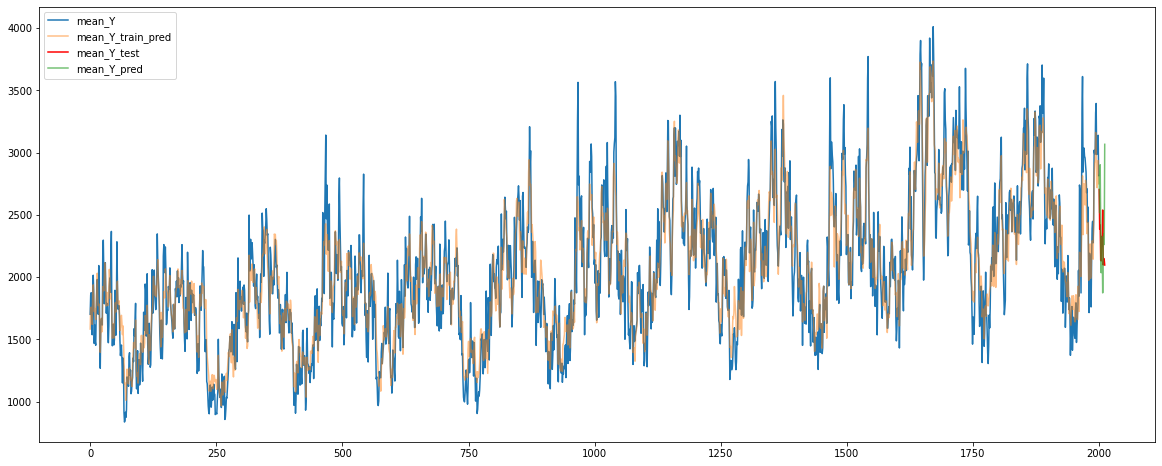

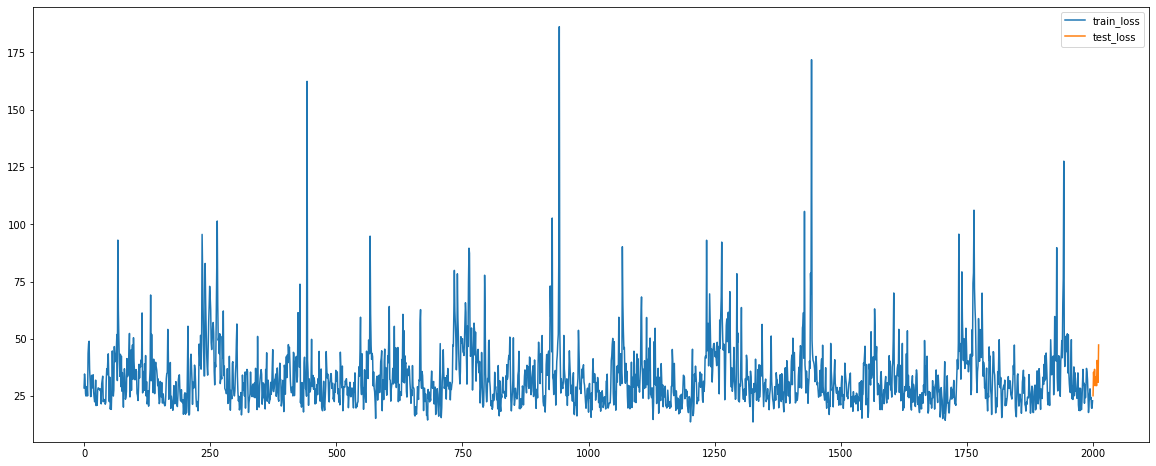

In [89]:
tscv.plot_cv_results(quality = dtreg_quality, horizons = dtreg_horizons, plot_loss = True)

In [90]:
dtreg_importances_dict = tscv.get_importances(dtreg_quality, dtreg_horizons, False)

dtreg_imp_features_0 = list(dtreg_importances_dict['target_carbon_monoxide'][0][(dtreg_importances_dict['target_carbon_monoxide'][0] >= .001) | (dtreg_importances_dict['target_carbon_monoxide'][0] <= -0.001)].index)
dtreg_imp_features_1 = list(dtreg_importances_dict['target_benzene'][0][(dtreg_importances_dict['target_benzene'][0] >= 1) | (dtreg_importances_dict['target_benzene'][0] <= -1)].index)
dtreg_imp_features_2 = list(dtreg_importances_dict['target_nitrogen_oxides'][0][(dtreg_importances_dict['target_nitrogen_oxides'][0] >= 1) | (dtreg_importances_dict['target_nitrogen_oxides'][0] <= -1)].index)

In [107]:
dtreg_importances_dict['target_benzene'][4]

lag_deg_C_6                      0.001103
lag_deg_C_7                      0.001103
lag_deg_C_8                      0.001103
lag_deg_C_9                      0.001103
lag_deg_C_10                     0.001103
                                   ...   
lag_target_nitrogen_oxides_20    0.001103
lag_target_nitrogen_oxides_21    0.001103
lag_target_nitrogen_oxides_22    0.001103
lag_target_nitrogen_oxides_23    0.001103
lag_target_nitrogen_oxides_24    0.001103
Length: 380, dtype: float64

### Random forest

In [110]:
from sklearn.ensemble import RandomForestRegressor

In [111]:
class RFReg_model:
    def __init__(self, rfreg):
        self.rfreg = rfreg
    def fit(self, X, Y):
        Y = np.reshape(Y, (Y.shape[0],))
        fitted_model = self.rfreg.fit(X, Y)
        self.importances = fitted_model.feature_importances_
        return fitted_model
    def predict(self, X):
        return np.reshape(self.rfreg.predict(X), (X.shape[0],1))

In [112]:
rfreg_model = RFReg_model(RandomForestRegressor(max_depth = 4, bootstrap = False))
rfreg_horizons = 6
rfreg_CrossValid_params = {'train_size' : 2000, 'test_size' : 1, 'min_period' : 0, 'step' : 500}
rfreg_ForecastModel_params = {'features' : features, 'date_time' : date_time_features,
                              'prior_lag' : 12, 'post_lag' : 0, 'new_index' : True}

In [113]:
#rfreg_quality = tscv.run_cv(data = df, targets = targets, horizons = rfreg_horizons, CrossValid_params = rfreg_CrossValid_params, 
#            ForecastModel_params = rfreg_ForecastModel_params, model = rfreg_model, metrics = mape)

In [114]:
#tscv.plot_cv_results(quality = rfreg_quality, horizons = rfreg_horizons, plot_loss = True)

In [115]:
#rfreg_quality['target_benzene']['forecast_model'][0].data.columns

### Xgboost

In [116]:
from xgboost import XGBRegressor

In [117]:
class XGBRegModel:
    def __init__(self, model):
        self.model = model
    def fit(self, X, Y):
        fitted_model = self.model.fit(X, Y)
        self.importances = fitted_model.feature_importances_
        return fitted_model
    def predict(self, X):
        return self.model.predict(X)

In [118]:
xgb_model = XGBRegModel(XGBRegressor(max_depth = 3, reg_alpha = .1))
xgb_horizons = 10
xgb_CrossValid_params = {'train_size' : 2000, 'test_size' : 1, 'min_period' : 0, 'step' : 500}
xgb_ForecastModel_params = {'features' : features, 'date_time' : date_time_features,
                              'prior_lag' : 12, 'post_lag' : 0, 'new_index' : True}

In [120]:
xgb_quality = tscv.run_cv(data = df, targets = targets, horizons = xgb_horizons, CrossValid_params = xgb_CrossValid_params, 
                          ForecastModel_params = xgb_ForecastModel_params, model = xgb_model, metrics = mape)

/home/alexey/notebooks/EPAM/practice_1/time_series_module.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  data['lag_' + c + '_' + str(l)] = lagged(data, c, l)


target_carbon_monoxide


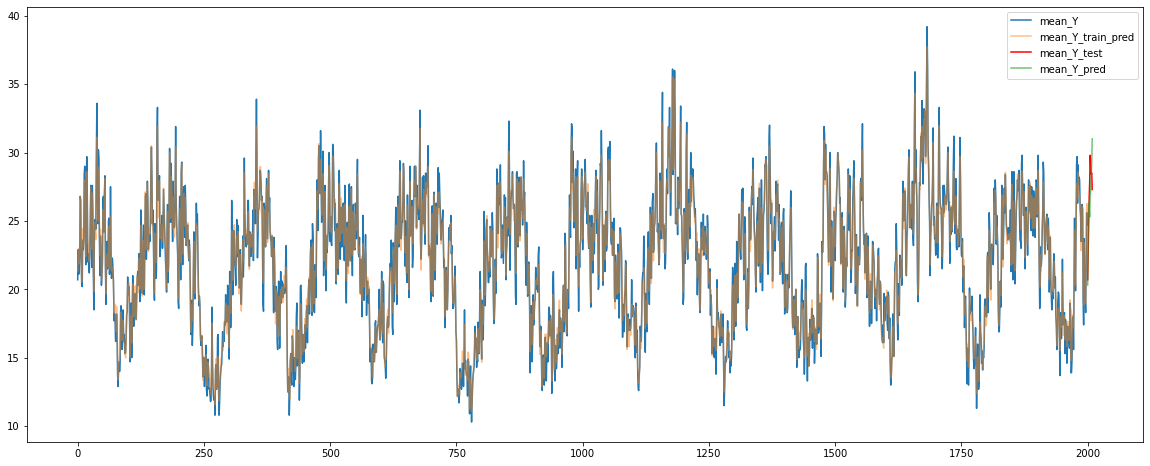

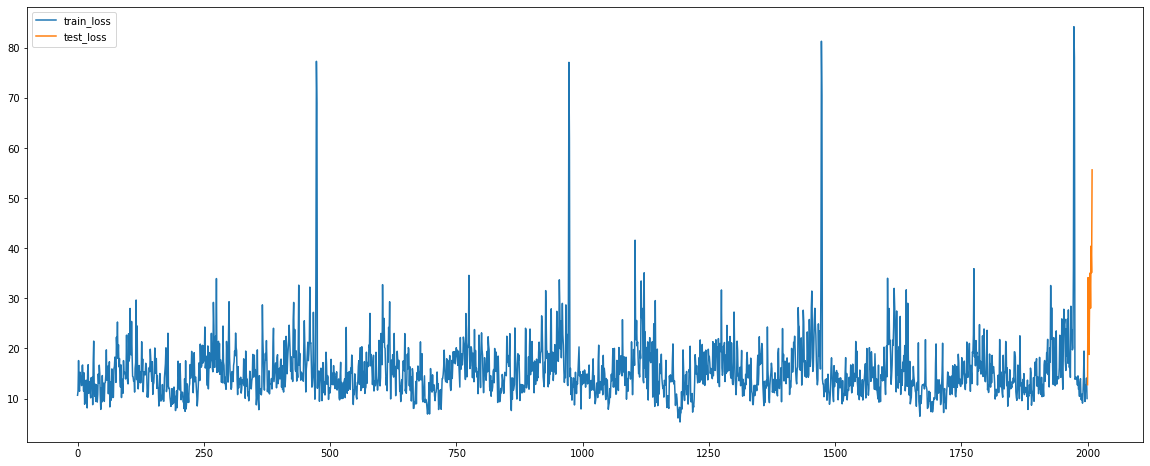

target_benzene


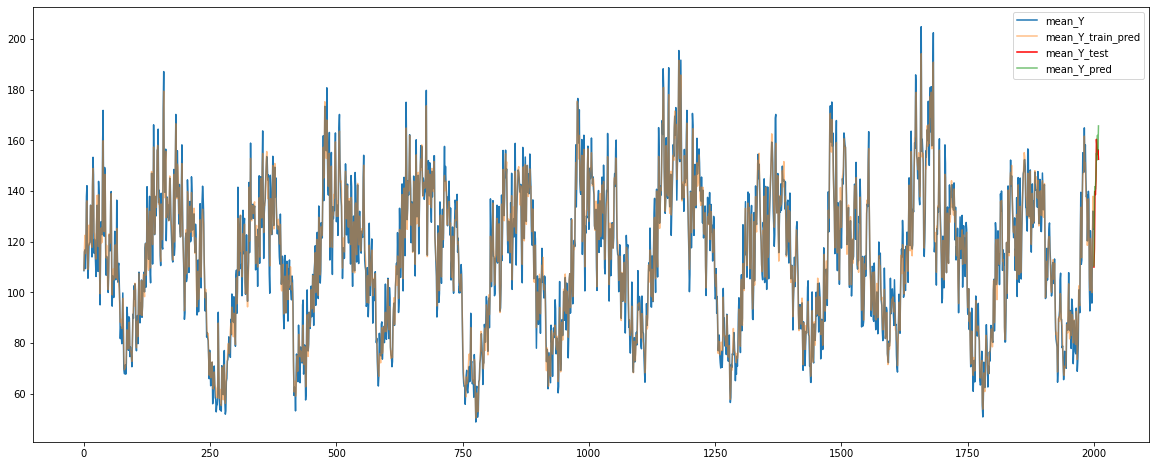

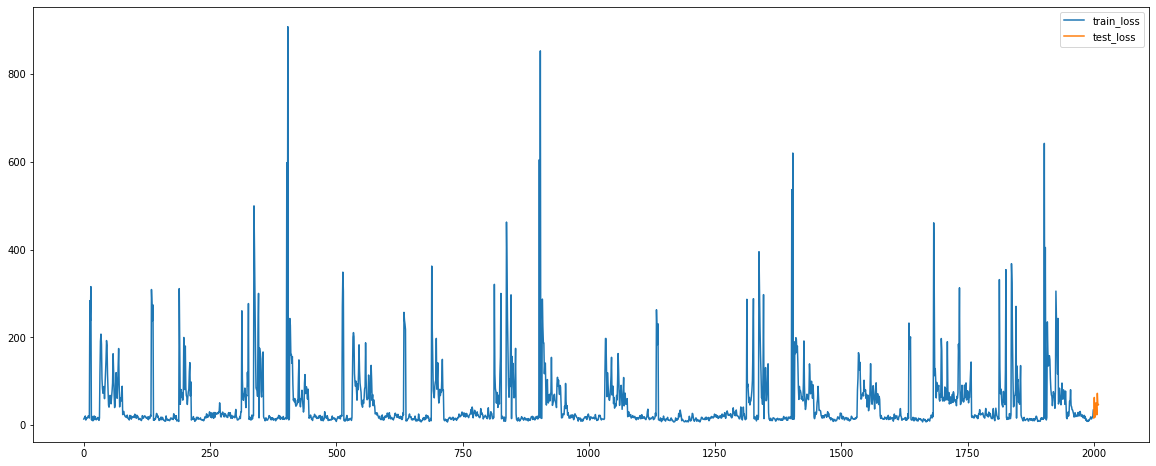

target_nitrogen_oxides


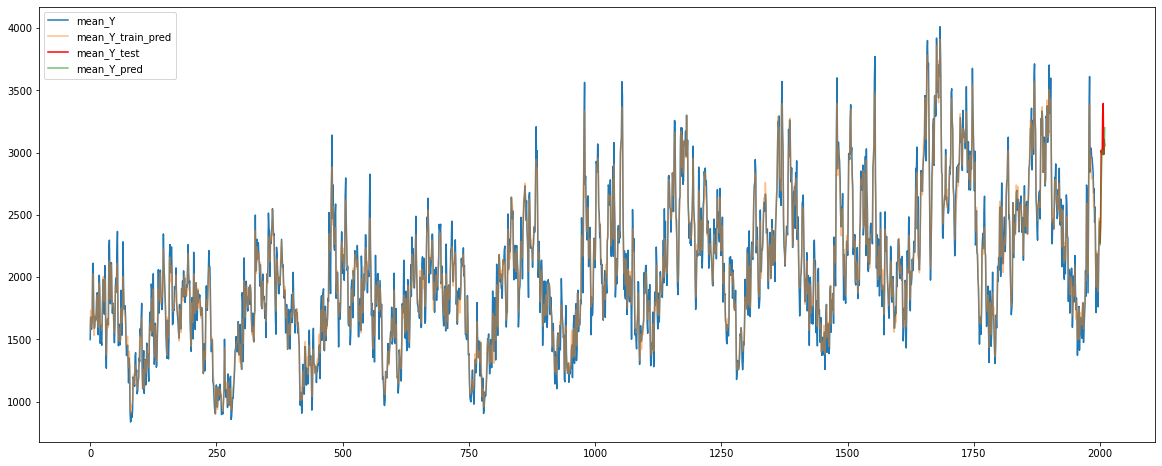

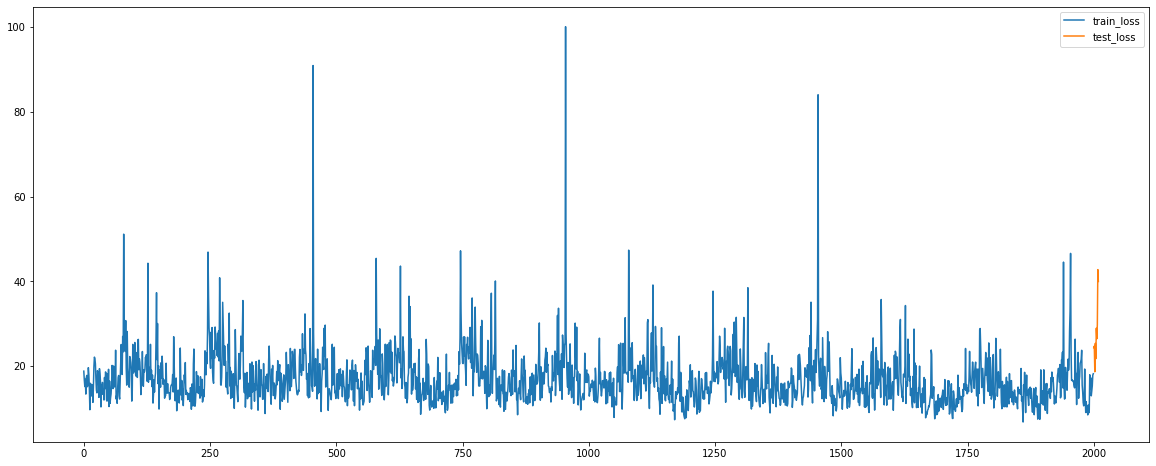

In [121]:
tscv.plot_cv_results(quality = xgb_quality, horizons = xgb_horizons, plot_loss = True)

In [122]:
xgb_importances_dict = tscv.get_importances(xgb_quality, xgb_horizons, False)

In [ ]:
reload(tscv)

In [ ]:
data_versions.push(tsver.nested_data(data = df, features = features, targets = targets,
                                     date_time = [date_time_column, date_time_features], 
                                     model = {'models' : [ridge_model, dtreg_model, xgb_model],
                                              'horizons' : [ridge_horizons, dtreg_horizons, xgb_horizons],
                                              'forecast_model' : [ridge_ForecastModel_params, dtreg_ForecastModel_params,
                                                                  xgb_ForecastModel_params],
                                              'cv_model' : [ridge_CrossValid_params, dtreg_CrossValid_params,
                                                            xgb_CrossValid_params]},
                                     accuracy = {'ridge' : tscv.get_losses(ridge_quality, ridge_horizons),
                                                 'dtreg' : tscv.get_losses(dtreg_quality, dtreg_horizons),
                                                 'xgb' : tscv.get_losses(xgb_quality, xgb_horizons)}),
                                     key = 'some_models')